In [31]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading']='auto'

In [32]:
# Load ecco data
rootdir = '../'
localdir = 'data/processed/ECCO/'
filename = 'binned_vol_budget_month_dGamman_0.1.nc'
ecco = xr.open_dataset(rootdir+localdir+filename)
# Make some naming adjustments
ecco['G'] = ecco['bin_FORC'].copy()
ecco['dMdt'] = ecco['bin_TEN'].copy()
# Load erai-en4 data
localdir = 'data/processed/ERAi_EN4/'
filename = 'mass_in_gamma.nc'
erai = xr.open_dataset(rootdir+localdir+filename).transpose()
# Shift the coordinates to correspsond with ECCO
erai = erai.rename({'gamman_bin':'gamma_n'}).assign_coords({'gamma_n':ecco['gamma_n'][:-2]})

In [33]:
# Construct M for ECCO as it is in ERAi
M_on_gamma_cumsum = xr.concat([xr.zeros_like(ecco['bin_vol'].isel({'gamma_n':0})),
                               ecco['bin_vol'].cumsum('gamma_n')],dim='gamma_n')
# We wish to have the total mass for the volume with temperature greater than that contour,
# So take away the total sum from the cumulative sum to reverse the direction
M_reverse = (ecco['bin_vol'].sum('gamma_n')-M_on_gamma_cumsum)
# Now we can get rid of the boundary contours, which were there to ensure that all
# of the volume wass captures, and we assign the coordinates to match with G
ecco['M'] = M_reverse.isel(gamma_n=slice(1,None)).assign_coords({'gamma_n':ecco['gamma_n']})
ecco['M'] = ecco['M'].transpose()

In [34]:
# Define the time-period for comparison
start = '1994-01-01'
end = '2016-12-31'
months = pd.date_range(start,end,freq='1M')
years = pd.date_range(start,end,freq='1Y')
gs = ecco['gamma_n'].sel({'gamma_n':slice(26.1,28.4)})
select = {'time':slice(start,end),'gamma_n':gs}

### Time-mean

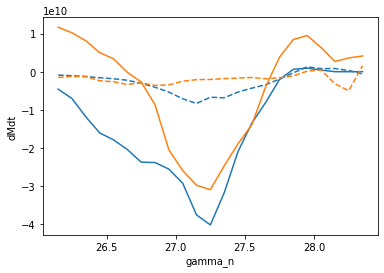

In [35]:
erai['G'].sel(select).mean('time').plot(color='tab:blue')
erai['dMdt'].sel(select).mean('time').plot(color='tab:blue',linestyle='--')
ecco['G'].sel(select).mean('time').plot(color='tab:orange')
ecco['dMdt'].sel(select).mean('time').plot(color='tab:orange',linestyle='--')

### Each year annual average

In [36]:
def _annual(da):
    annual = da.coarsen(time=12,boundary='trim').mean()
    return annual
def _annualanom(da):
    annual = da.coarsen(time=12,boundary='trim').mean()
    mean = da.mean('time')*xr.ones_like(annual)
    annualanom = annual-mean
    return annualanom
def _anom(da):
    mean = da.mean('time')*xr.ones_like(da)
    anom = da-mean
    return anom

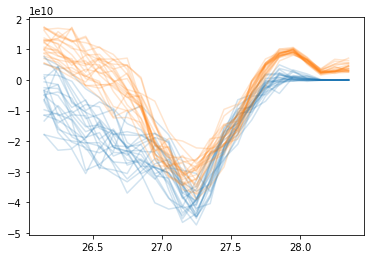

In [37]:
plt.plot(gs,_annual(erai['G'].sel(select)),color='tab:blue',alpha=0.2);
plt.plot(gs,_annual(ecco['G'].sel(select)),color='tab:orange',alpha=0.2);

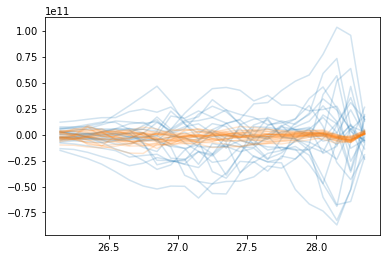

In [38]:
plt.plot(gs,_annual(erai['dMdt'].sel(select)),color='tab:blue',alpha=0.2);
plt.plot(gs,_annual(ecco['dMdt'].sel(select)),color='tab:orange',alpha=0.2);

### Colormeshes of dMdt

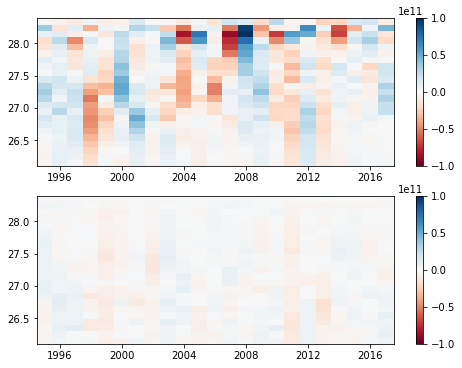

In [39]:
clims = [-1E11,1E11]
fig,ax = plt.subplots(figsize=(8,6),nrows=2)
im = ax[0].pcolormesh(years,gs,
                      _annualanom(erai['dMdt'].sel(select)),
                      vmin = clims[0],vmax = clims[1], cmap='RdBu')
plt.colorbar(im,ax=ax[0])
im = ax[1].pcolormesh(years,gs,
                      _annualanom(ecco['dMdt'].sel(select)),
                      vmin = clims[0],vmax = clims[1], cmap='RdBu')
plt.colorbar(im,ax=ax[1])

### Take a closer look at the volume

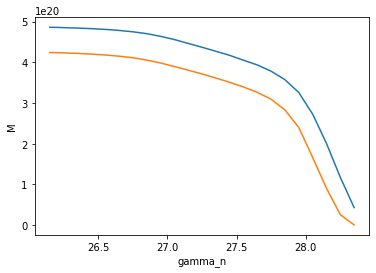

In [40]:
erai['M'].sel(select).mean('time').plot()
ecco['M'].sel(select).mean('time').plot()

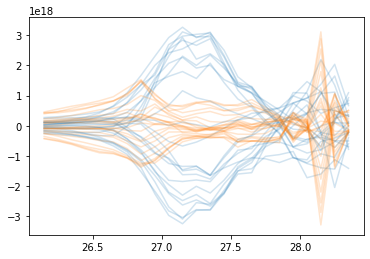

In [41]:
plt.plot(gs,_annualanom(erai['M'].sel(select)),color='tab:blue',alpha=0.2);
plt.plot(gs,_annualanom(ecco['M'].sel(select)),color='tab:orange',alpha=0.2);

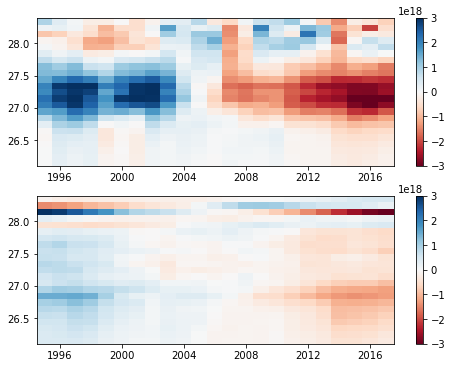

In [42]:
clims = [-3E18,3E18]
fig,ax = plt.subplots(figsize=(8,6),nrows=2)
im = ax[0].pcolormesh(years,gs,
                      _annualanom(erai['M'].sel(select)),
                      vmin = clims[0],vmax = clims[1], cmap='RdBu')
plt.colorbar(im,ax=ax[0])
im = ax[1].pcolormesh(years,gs,
                      _annualanom(ecco['M'].sel(select)),
                      vmin = clims[0],vmax = clims[1], cmap='RdBu')
plt.colorbar(im,ax=ax[1])

- quite clearly, Ivana's dMdt is not the same as mine
- when I look at the total mass greater than the ispycnal, then they look rather similar
- but if the summed tendency (Ivana's calculation) is balanced, then the calculation as I have it will not be
- what, then, is Ivana's tendency term?